In [5]:
import numpy as np
import rioxarray as rxr
import matplotlib.pyplot as plt
from IPython.display import clear_output
from osgeo import gdal_array

In [6]:
%%time
# Read raster data as numeric array from file
image_filename = '/att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/pansharpen_TamNongClip/WV02_20130125_M1BS_103001001DD53500-toa_pansharpen_clip.tif'
rasterArray = gdal_array.LoadFile(image_filename)
rasterArray.shape

CPU times: user 43.1 s, sys: 13.6 s, total: 56.7 s
Wall time: 59.8 s


(4, 38702, 71223)

In [7]:
type(rasterArray)

numpy.ndarray

In [8]:
%%time
image_filename = '/att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/pansharpen_TamNongClip/WV02_20130125_M1BS_103001001DD53500-toa_pansharpen_clip.tif'
image_data = rxr.open_rasterio(image_filename)
image_array = image_data.values
image_array.shape

CPU times: user 42.7 s, sys: 11.9 s, total: 54.7 s
Wall time: 54.7 s


(4, 38702, 71223)

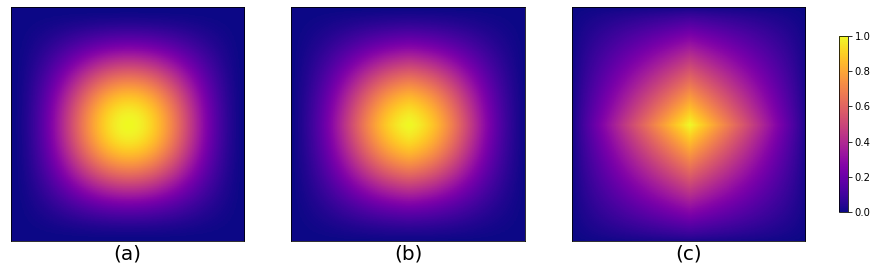

In [9]:
import scipy.signal
import scipy.signal.windows as w
'''
Generates a 2D square image (of size window_size) containing a 2D user-defined
window with values ranging from 0 to 1.
It is possible to pass arguments to the window function by setting kwargs.
All available windows: https://docs.scipy.org/doc/scipy/reference/signal.windows.html
'''
def window2d(window_func, window_size, **kwargs):
    window = np.matrix(window_func(M=window_size, sym=False, **kwargs))
    return window.T.dot(window)

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.set_xlabel(['(a)', '(b)', '(c)'][i], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 3:
        pyra = get_loss_weight(128, 128, 1, stride_height=0, stride_width=0, batch_size=1, border =0)
        ax.imshow(pyra, cmap='plasma')
    else:
        w_type = [w.hann, w.barthann, w.triang][i]
        im = ax.imshow(window2d(w_type, 128), cmap='plasma', vmin=0, vmax=1)
plt.colorbar(im, ax=axes.flat, pad=0.04, fraction=0.0105)
plt.show()

In [10]:
def generate_corner_windows(window_func, window_size, **kwargs):
    step = window_size >> 1
    window = window2d(window_func, window_size, **kwargs)
    window_u = np.vstack([np.tile(window[step:step+1, :], (step, 1)), window[step:, :]])
    window_b = np.vstack([window[:step, :], np.tile(window[step:step+1, :], (step, 1))])
    window_l = np.hstack([np.tile(window[:, step:step+1], (1, step)), window[:, step:]])
    window_r = np.hstack([window[:, :step], np.tile(window[:, step:step+1], (1, step))])
    window_ul = np.block([
        [np.ones((step, step)), window_u[:step, step:]],
        [window_l[step:, :step], window_l[step:, step:]]])
    window_ur = np.block([
        [window_u[:step, :step], np.ones((step, step))],
        [window_r[step:, :step], window_r[step:, step:]]])
    window_bl = np.block([
        [window_l[:step, :step], window_l[:step, step:]],
        [np.ones((step, step)), window_b[step:, step:]]])
    window_br = np.block([
        [window_r[:step, :step], window_r[:step, step:]],
        [window_b[step:, :step], np.ones((step, step))]])
    return np.array([
        [ window_ul, window_u, window_ur ],
        [ window_l,  window,   window_r  ],
        [ window_bl, window_b, window_br ],
    ])

In [18]:
'''
Returns all the possible coordinates and size of patches and appropriate windows
to use on a given image. The hanning option makes the windows overlap, by half
a window size. This changes the complexity as follows:
+=========+==================+
| hanning |    complexity    |
+=========+==================+
| False   | O(N^2)           |
| True    | O(4N^2 - 4N + 1) |
+---------+------------------+
For a square image of size M with patches of size L, N the number of patches that
can fit one dimension of the image, N = int(M/L) 
'''
def generate_patch_list(image_width, image_height, window_func, window_size, overlapping=False):
    patch_list = []
    if overlapping:
        step = window_size >> 1
        windows = generate_corner_windows(window_func, window_size)
        max_height = int(image_height/step - 1)*step
        max_width = int(image_width/step - 1)*step
        print("max_height, max_width", max_height, max_width)
    else:
        step = window_size
        windows = np.ones((window_size, window_size))
        max_height = int(image_height/step)*step
        max_width = int(image_width/step)*step
        print("else max_height, max_width", max_height, max_width)
    
    for i in range(0, max_height, step):
        for j in range(0, max_width, step):
            if overlapping:
                # Close to border and corner cases
                # Default (1, 1) is regular center window
                border_x, border_y = 1, 1
                if i == 0: border_x = 0
                if j == 0: border_y = 0
                if i == max_height-step: border_x = 2
                if j == max_width-step: border_y = 2
                # Selecting the right window
                current_window = windows[border_x, border_y]
            else:
                current_window = windows
            # The patch is cropped when the patch size is not
            # a multiple of the image size.
            patch_height = window_size
            if i+patch_height > image_height:
                patch_height = image_height - i
            patch_width = window_size
            if j+patch_width > image_width:
                patch_width = image_width - j
            # Adding the patch
            patch_list.append(
                (j, i, patch_width, patch_height, current_window[:patch_height, :patch_width])
            )
    return patch_list

In [24]:
%%time
window_func = w.hann
use_hanning = True
tile_size = 16000
image_shape = image_array.shape
patch_list = generate_patch_list(image_shape[1], image_shape[2], window_func, tile_size, use_hanning)

#M = np.zeros((image_array.shape[1], image_array.shape[2])) # Output image
#patch_list = generate_patch_list(image_array.shape[1], image_array.shape[2], window_func, tile_size, use_hanning)
len(patch_list)

max_height, max_width 56000 24000
CPU times: user 16 s, sys: 21.4 s, total: 37.4 s
Wall time: 28.1 s


21

In [20]:
#%%time
#counter = 0
for patch in patch_list:
    patch_x, patch_y, patch_width, patch_height, window = patch
    print(patch_x, patch_y, patch_width, patch_height)
    #patch_x, patch_y, patch_width, patch_height, window = patch
    #input_path = image_data[patch_y:patch_y+patch_height, patch_x:patch_x+patch_width].values
    
# prediction = np.ones_like(window) * np.random.randint(0, 2) # Simulated patch
# input_path = input_image[patch_y:patch_y+patch_height, patch_x:patch_x+patch_width]
# prediction = model(input_patch)
#input_path = image_data[patch_y:patch_y+patch_height, patch_x:patch_x+patch_width].data
#print(input_path.data)
#prediction = model(input_patch)
#M[patch_y:patch_y+patch_height, patch_x:patch_x+patch_width] += prediction * window
#print(counter)

In [21]:
#tile_size = 16000
#image_shape = (38702, 71223, 4)
#step = tile_size >> 1

#max_height = int(image_shape[0]/step)*step
#max_width = int(image_shape[1]/step)*step
#print(max_height, max_width)

In [22]:
#counter = 0
#for i in range(0, max_height, step):
#    for j in range(0, max_width, step):
#        print(i, i+step, j, j+step)
#        counter += 1
#print(counter)

In [26]:
34320 % 30000

4320